# "Wiener Linien" Minute

Anyone who has used the Vienna public transport system has probably used the Wiener Linien.

And if they payed close attention to the departure monitor, they might have noticed some inconsistencies within the displayed and the actual arriving times. Sometimes the monitor says the next train will "arrive in 4 minutes" for over two minutes and other times the "4 minute" arrival time will display for less then half a minute. This is because the departure monitors don't actually display arrival times according to the schedule, but instead take guesses based on the position of the train/tram/bus/etc. .

So the question any reasonable passenger is thinking is: How accurate are these predictions, and are there any patterns one can observe?

## Data acquisition

Instead of having to manually sit at the subway station and take timings, the Wiener Linien have decided to provide the departure monitors' data publicly for free [via their open data api](https://www.data.gv.at/katalog/dataset/wiener-linien-echtzeitdaten-via-datendrehscheibe-wien/resource/ce15bc47-696f-4ff8-81f3-4ee0737d95de)

For this project I implemented a data-scraper script that periodically pulls the data for a certain station from the api. It can be run with the 'data_scraper_deploy.py' script by simply using the command line - for example:

`python3 data_scraper_deploy.py >> scrape.log` to get logging output to scrape.log

(here's the contents of the data_scraper_deploy.py file for context):

```{python}
import wienerLinien.datascraper as ds

scraper = ds.Scraper(outFile="scrape.csv", station="Längenfeldgasse", mode="a")
scraper.run(None) # run indefinitely
```

For this project the data scraper was run for multiple weeks with some interruptions, but more on the dataset later. Requests were sent every 10 to 15 seconds (started with 10 s and switched to 15 s after encountering rate limitations).

## Data preperation

Data preperation was the most challenging part of the task. The initial dataframe looks something like this:

In [1]:
import pandas as pd

dataset = pd.read_csv('./data/scrape_combined_2021-12-29.csv.gz')
dataset

,station,line,towards,countdown,time
0,Längenfeldgasse U,12A,Eichenstraße,"[6, 13, 24, 34, 44, 54, 64]",1.637752e+09
1,Längenfeldgasse U,12A,"Schmelz, Gablenzgasse","[1, 12, 21, 30, 40, 50, 60]",1.637752e+09
2,"Flurschützstraße, Längenfeldgasse",62,"Lainz, Wolkersbergenstraße","[3, 11, 17, 25, 32, 40, 47, 55, 62]",1.637752e+09
3,"Flurschützstraße, Längenfeldgasse",62,"Oper, Karlsplatz U","[0, 8, 14, 25, 30, 38, 45, 53, 60, 68]",1.637752e+09
4,Flurschützstraße / Längenfeldgasse,63A,Am Rosenhügel,"[0, 12, 22, 32, 42, 52, 59, 67]",1.637752e+09
...,...,...,...,...,...
2250410,Längenfeldgasse,U4,HÜTTELDORF,"[0, 5, 11, 19, 26, 34, 41, 49, 56, 64]",1.640814e+09
2250411,Längenfeldgasse,U6,FLORIDSDORF,"[7, 16, 21, 29, 36, 44, 51, 59, 66]",1.640814e+09
2250412,Längenfeldgasse,U6,SIEBENHIRTEN,"[4, 12, 19, 26, 34, 41, 49, 56, 64]",1.640814e+09
2250413,"Flurschützstraße, Längenfeldgasse",WLB,Wien Oper,"[9, 24, 39, 54, 69]",1.640814e+09


As seen above, the dataset consists of a table containing the station, line, direction, countdowns for the next few arrivals and the time when the data was pulled.

We can also see that the dataset consists of over 2 million entries beginning at November 24th 2021 with the last entry on December 29th 2021.

So now to get anything meaningful out of this, the data had to be separated into station/line/towards combinations. Then for each distinct combination of interest, the vehicles (trains, trams, busses, etc.) had to be tracked using the countdown data. This is especially tricky as the position within the countdown array changes with time and sometimes trains will just be left out (this predominantly happens at the end of the countdown list while the first few positions are almost never affected). Also, sometimes the api rate limited the requests and there were a few occurences where the dataset was interrupted by minutes, hours or days (for example because of an unhandled exception or a non-scheduled server-restart). Measures were taken to filter out these bad samples as good as possible.

The resulting logic was implemented in the "wienerLinien" package, more specifically in the "apiData" class which is part of the "analyse" module.

So let's jump straight into the dataset...

### Loading the dataset

The dataset is loaded by simply instantiating a new apiData object passing the dataset as argument

In [2]:
from wienerLinien.analyse import apiData

api_file = './data/scrape_combined_2021-12-29.csv.gz'

if __name__ == '__main__':
    data_class = apiData(api_file)

### View and select station/line/direction pairs

After loading the dataset, we need to first view the available station/line/direction combinations and then select the ones we are interested in.

This can be done by the `getAvailable()` method which neatly lists all present combinations including the number of occurences per combination. The function also performs some rudimentary filtering to exclude most special announcements made via the departure monitors.

In [3]:
data_class.getAvailable().head(10)

,station,line,towards,count
295,Längenfeldgasse,U6,SIEBENHIRTEN,177221
225,Längenfeldgasse,U6,FLORIDSDORF,175275
71,Längenfeldgasse,U4,HÜTTELDORF,175096
1,Flurschützstraße / Längenfeldgasse,63A,Gesundheitszentrum Süd,175067
0,Flurschützstraße / Längenfeldgasse,63A,Am Rosenhügel,174809
30,Längenfeldgasse,U4,HEILIGENSTADT,172561
14,"Flurschützstraße, Längenfeldgasse",62,"Oper, Karlsplatz U",171747
12,"Flurschützstraße, Längenfeldgasse",62,"Lainz, Wolkersbergenstraße",166386
304,Längenfeldgasse U,12A,"Schmelz, Gablenzgasse",166263
22,"Flurschützstraße, Längenfeldgasse",WLB,Wien Oper,156843


In this example we're interested in the U4 towards Heiligenstadt as it leads directly to BOKU and tram 62 towards Lainz because it leads to the Lainzer Tiergarten and it's quite nice there.

In [4]:
chosen = data_class.getAvailable().loc[[30, 12]][['station', 'line', 'towards']].values
chosen

array([['Längenfeldgasse', 'U4', 'HEILIGENSTADT'],
       ['Flurschützstraße, Längenfeldgasse', '62',
        'Lainz, Wolkersbergenstraße']], dtype=object)

### Track departures over time

The next step is to transform the data in our dataset into something useful. The `trackMany()` method is used. It takes a set of chosen station/line/towards combinations and tries to track the arriving vehicles over time using the countdown list and some algorithm I came up with.

The depth is the number of first entries in the countdown list to take into account. The max_diff parameter describes how many seconds may have passed between entries in the dataset to be considered cohesive. Multithreading is also implemented, so when including more than one combination in the `which` list, multiple processes are spawned using the multiprocessing library. This does not work in Windows (at least not in my installation) and therefore is limited to Linux (and possibly OSX devices (not tested)).

Because of the size of the dataset, this operation may take several minutes. Also, take note that in order to reduce clutter, I opted to not display progress bars for some finalizing calculations. It therefore may take some additional time (approx. 2-3 minutes) per track to finish the calculations after the progress bar is complete.

Because of the time it takes to perform these calculations, the resulting object is also pickled. You may choose if you want to use the pickled data or calculate the data yourself at the beginning of the next code cell:

In [5]:
import dill as pickle
import platform
import os
import gzip

processes = 4
lazyLoad = True # If true, trying to retrieve an already calculated object from the storage_file
pickling = True # It true, save the result to the storage_file. This option is ignored when lazyLoad is enabled.

storage_file = 'datastore.gz'

if lazyLoad:
    data_class = pickle.load(gzip.open(storage_file, mode='rb'))

else:
    if pickling:
        if os.path.isfile(storage_file):
            confirm = input(f'File {storage_file} already exists. Do you really want to override it? (y/n)')

            if confirm == 'y':
                pass
            else:
                print('Aborting...')
                raise KeyboardInterrupt

    if platform.system() == 'Windows':
        processes = 0

    data_class.trackMany(which=chosen, depth=2, max_diff=16, multithreaded=processes)

    if pickling:
        with gzip.open(storage_file, 'wb') as s:
            pickle.dump(data_class, s)

## Data analysis

Now that we're done with the data preparation, we can start to explore the dataset.

We start by pulling and combining the calculated datasets and calculate some basic descriptors

In [6]:
U4H = data_class.fetchResults(which=chosen[0])
L62Lainz = data_class.fetchResults(which=chosen[1])

In [7]:
with pd.option_context('mode.chained_assignment',None):
    U4H['desc'] = 'U4 Heiligenstadt'
    L62Lainz['desc'] = 'Line 62 Lainz'
combined_df = pd.concat([U4H, L62Lainz], ignore_index=True)
combined_df

,countdown,start,end,complete,hour,warning,dt,desc
0,1.0,1.637752e+09,1.637752e+09,True,12.0,False,20.657989,U4 Heiligenstadt
1,0.0,1.637752e+09,1.637752e+09,True,12.0,False,41.495077,U4 Heiligenstadt
2,7.0,1.637752e+09,1.637752e+09,True,12.0,False,62.153066,U4 Heiligenstadt
3,6.0,1.637752e+09,1.637752e+09,True,12.0,False,20.849093,U4 Heiligenstadt
4,5.0,1.637752e+09,1.637752e+09,True,12.0,False,51.886632,U4 Heiligenstadt
...,...,...,...,...,...,...,...,...
94041,5.0,1.640629e+09,1.640629e+09,True,19.0,False,10.313045,Line 62 Lainz
94042,2.0,1.640629e+09,1.640630e+09,True,19.0,False,41.731123,Line 62 Lainz
94043,13.0,1.640767e+09,1.640767e+09,True,9.0,False,15.339216,Line 62 Lainz
94044,11.0,1.640767e+09,1.640767e+09,True,9.0,False,15.341712,Line 62 Lainz


In [8]:
combined_df[['dt', 'countdown', 'desc']].groupby('desc').describe().T

desc             Line 62 Lainz  U4 Heiligenstadt
dt        count   51496.000000      42550.000000
          mean       48.944576         57.872185
          std        26.457523         41.194857
          min        10.241672         10.252564
          25%        30.976773         32.492368
          50%        51.749657         51.860357
          75%        62.215849         72.407201
          max       449.746644       1807.031650
countdown count   51496.000000      42550.000000
          mean       10.367388          4.758895
          std         9.942820          4.348093
          min         0.000000          0.000000
          25%         4.000000          2.000000
          50%         8.000000          4.000000
          75%        13.000000          7.000000
          max        69.000000         44.000000

As we can see in this overview of the data, the mean duration of a minute is close to 60 s, but may differ by a lot. While the mean of U4 Heiligenstadt is closer to 60 s than Line 62 Lainz, the standard deviation is also larger. The longest recorded time a single countdown was displayed was around 7.5 minutes for Line 62 and 30 minutes for U4, although this could be an artifact in the dataset which would need further investigation.

One can also observe, that the mean combined time for the next two departures (as we've limited the tracking to the next two departures) is more than double for Line 62 than for U4, indicating a tighter schedule for the U4.

The differences in counts may be due to filtered departure monitor announcements which interrupt a track.

### Duration of a minute depending on the displayed departure time

Now, let's have a closer look at the durations of a minute in dependence of the displayed departure time

First, we calculate significance levels using a Wilcoxon test to test if the sample median is significantly different to the expected median of 60 s.

In [9]:
from scipy.stats import wilcoxon
import numpy as np

def getSigLevel(p):
    # We define significance levels for p < 0.1 (*), 0.05 (**) and 0.01 (***)
    if p < 0.1:
        if p < 0.05:
            if p < 0.01:
                return '***'
            return '**'
        return '*'
    else:
        return ''

def calculateWilcoxonGroups(df, groups):
    grouped = df.pivot_table(columns=groups, values='dt', aggfunc=np.median).melt()
    grouped['p'] = df.groupby(groups).apply(lambda d: wilcoxon(d['dt']-60)[1]).values
    grouped['sig'] = grouped.apply(lambda d: getSigLevel(d['p']), axis=1)
    grouped = grouped.rename(columns={'value':'median'})

    return grouped

groups_cntwn = ['desc', pd.cut(combined_df['countdown'], bins = list(range(0,8))+[12,30,70], right=False) ]
sig_ctwn = calculateWilcoxonGroups(combined_df, groups_cntwn)
sig_ctwn

,desc,countdown,median,p,sig
0,Line 62 Lainz,"[0, 1)",62.112357,7.508021e-07,***
1,Line 62 Lainz,"[1, 2)",20.751818,0.000000e+00,***
2,Line 62 Lainz,"[2, 3)",62.064683,1.517922e-03,***
3,Line 62 Lainz,"[3, 4)",45.745023,3.418705e-275,***
4,Line 62 Lainz,"[4, 5)",41.434364,0.000000e+00,***
5,Line 62 Lainz,"[5, 6)",31.252600,0.000000e+00,***
6,Line 62 Lainz,"[6, 7)",51.873379,2.478414e-56,***
7,Line 62 Lainz,"[7, 12)",51.847165,1.371865e-210,***
8,Line 62 Lainz,"[12, 30)",51.900045,0.000000e+00,***
9,Line 62 Lainz,"[30, 70)",61.923874,3.558445e-11,***


Now we can create a boxplot that includes the significance levels

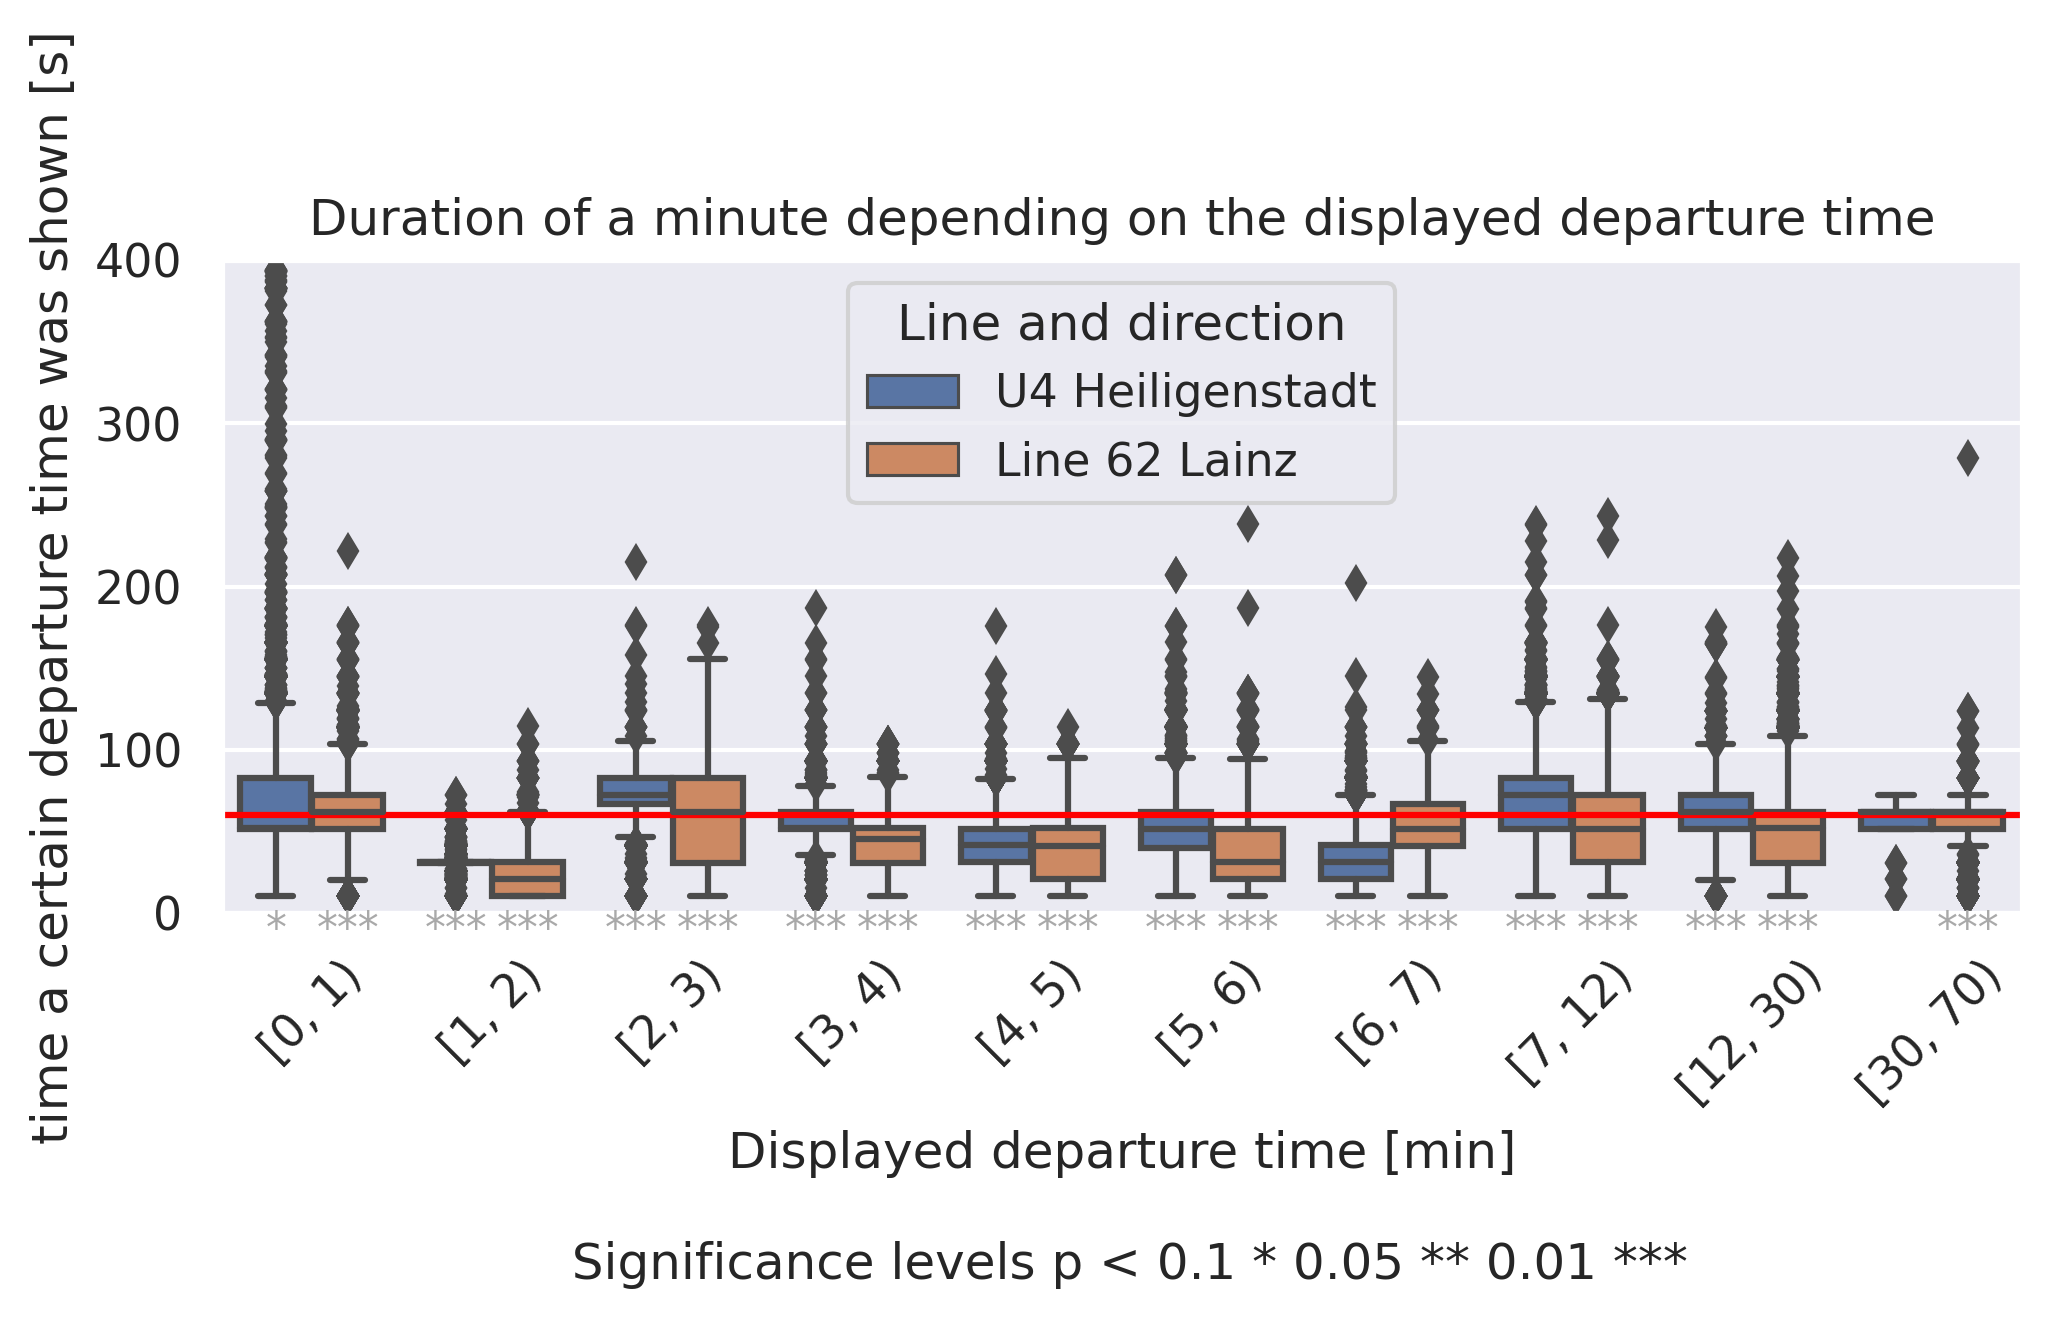

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(rc={'figure.figsize':(7,4), 'figure.dpi':300})
palette ={"U4 Heiligenstadt": "C0", "Line 62 Lainz": "C1"}

sns.boxplot(x=pd.cut(combined_df['countdown'], bins=list(range(0,8))+[12,30,70], right=False ), y=combined_df['dt'], hue=combined_df['desc'], palette=palette)
plt.ylim((0,400))
plt.xlim(-0.5,9.5)
plt.hlines(60, -1, 12, colors='red')
plt.title('Duration of a minute depending on the displayed departure time')
plt.xlabel('Displayed departure time [min]\n \n Significance levels p < 0.1 * 0.05 ** 0.01 ***')
plt.ylabel('time a certain departure time was shown [s]')
plt.legend(title='Line and direction')
plt.xticks(rotation=45)

yoffset = -10
n0 = 0
n1 = 0

for i, r in sig_ctwn.iterrows():
    if r['desc'] == 'Line 62 Lainz':
        x = n1  + 0.2
        n1 += 1
    else:
        x = n0 - 0.2
        n0 += 1
    
    y = yoffset
    #y = r['median'] + yoffset
    plt.text(x, y, r['sig'], ha='center', va='center', fontsize='small', color='darkgray')

plt.tight_layout()
plt.savefig('./figures/departure_boxplot.png')

<img src='./figures/departure_boxplot.png' width=600px>

As it can be seen in the boxplots, the duration of a minute changes depending on the displayed departure time.

While the boxplot of a departure time of 0 minutes (interval [0, 1) ) is nicely centered around 60 s, it exhibits a large spread, especially notable in U4 Heiligenstadt. The remaining departure times show that most of the time, a "Wiener Linien Minute" is less then a real minute. With the exception of minute 1 for U4 and minutes [30, 70) for Line 62, all medians were different from the expected median of 60 s with a significance level of p < 0.05. Another interesting trend to be observed it that the durations seems to get more accurate the longer the displayed departure time is.

The "accuracy" of a minute may be displayed as the mean of squared residuals to the expected value of 60 s

$$
\overline{SR} = \frac{\sum_{i=1}^{n} (60 s - dt_n)^2}{n}
$$

In [11]:
combined_df['SR'] = (60 - combined_df['dt'])**2
mean_ssr = combined_df.pivot_table(columns=['desc', 'countdown'], values='SR', aggfunc=np.mean).melt()
mean_ssr

,desc,countdown,value
0,Line 62 Lainz,0.0,572.906431
1,Line 62 Lainz,1.0,1420.082461
2,Line 62 Lainz,2.0,1111.096905
3,Line 62 Lainz,3.0,685.254315
4,Line 62 Lainz,4.0,816.140652
...,...,...,...
110,U4 Heiligenstadt,40.0,4.894338
111,U4 Heiligenstadt,41.0,14.519907
112,U4 Heiligenstadt,42.0,3.831187
113,U4 Heiligenstadt,43.0,14.809138


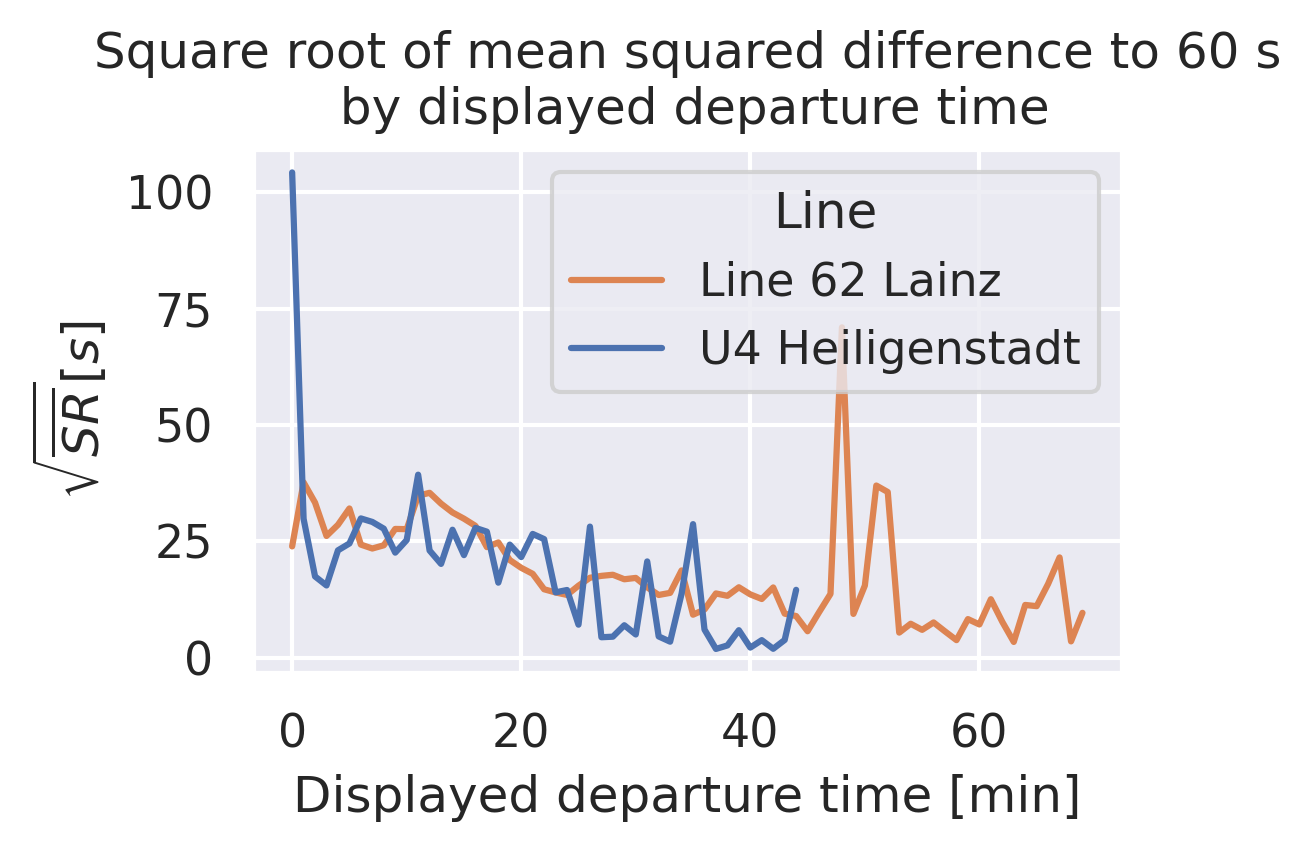

In [12]:
sns.set(rc={'figure.figsize':(4,3), 'figure.dpi':300})
sns.lineplot(x=mean_ssr['countdown'], y=np.sqrt(mean_ssr['value']), hue=mean_ssr['desc'], palette=palette)
plt.legend(title="Line")
plt.xlabel("Displayed departure time [min]")
plt.ylabel(r'$\sqrt{\overline{SR}} [s]$')
plt.title('Square root of mean squared difference to 60 s\n by displayed departure time')
plt.tight_layout()
plt.savefig('./figures/departure_lineplot.png')

<img src='./figures/departure_lineplot.png' width=600px>

As we can see in the above plot, larger departure times tend to be more accurate with some exceptions.

### Dependence on time of day

The accuracy of the predictions might differ with the time of the day. For example, in the rush-hour departures might be late because of congestion (mainly Line 62 as there's no other traffic on the subway rails) and it could be more accurate in late hours as there might be fewer variables to take into account for the departure predictions.

The time of day was already pulled from the time a certain countdown number started in the form of "hour of the day" (24 h format, timezone 'Europe/Vienna').
Because the countdown value '0' is not very useful for a passenger and had a very large spread, it was excluded from this analysis.

In [13]:
# Remove datasets where the countdown is 0
nonzero = combined_df.loc[combined_df['countdown'] != 0]
nonzero['SR'] = (60 - nonzero['dt'])**2
mean_ssr_hour = nonzero.pivot_table(columns=['desc', 'hour'], values='SR', aggfunc=np.mean).melt()

# calculate significance
groups_hrs = ['desc', pd.cut(nonzero['hour'], np.arange(0,25,2), right=False) ]
sig_hrs = calculateWilcoxonGroups(nonzero, groups_hrs)
sig_hrs

/tmp/ipykernel_3810/1634139343.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nonzero['SR'] = (60 - nonzero['dt'])**2


,desc,hour,median,p,sig
0,Line 62 Lainz,"[0, 2)",51.684905,7.285112e-16,***
1,Line 62 Lainz,"[4, 6)",61.906854,1.332297e-27,***
2,Line 62 Lainz,"[6, 8)",51.926657,8.130011e-97,***
3,Line 62 Lainz,"[8, 10)",51.756947,3.406258e-136,***
4,Line 62 Lainz,"[10, 12)",41.608905,1.471328e-240,***
5,Line 62 Lainz,"[12, 14)",41.605798,1.006600e-265,***
6,Line 62 Lainz,"[14, 16)",41.746777,2.480471e-262,***
7,Line 62 Lainz,"[16, 18)",42.519683,2.566234e-253,***
8,Line 62 Lainz,"[18, 20)",51.602768,4.455306e-224,***
9,Line 62 Lainz,"[20, 22)",51.750314,8.167143e-149,***


In the above dataframe, we have a missing row for Line 62 because there were no departures in [2,4). We need to add this row in order for the annotation function to work.

In [14]:
sig_hrs.loc[0.5] = 'Line 62 Lainz', '[2,4)', np.nan, np.nan, ''
sig_hrs.sort_index(inplace=True)
sig_hrs

,desc,hour,median,p,sig
0.0,Line 62 Lainz,"[0, 2)",51.684905,7.285112e-16,***
0.5,Line 62 Lainz,"[2,4)",NaN,NaN,
1.0,Line 62 Lainz,"[4, 6)",61.906854,1.332297e-27,***
2.0,Line 62 Lainz,"[6, 8)",51.926657,8.130011e-97,***
3.0,Line 62 Lainz,"[8, 10)",51.756947,3.406258e-136,***
4.0,Line 62 Lainz,"[10, 12)",41.608905,1.471328e-240,***
5.0,Line 62 Lainz,"[12, 14)",41.605798,1.006600e-265,***
6.0,Line 62 Lainz,"[14, 16)",41.746777,2.480471e-262,***
7.0,Line 62 Lainz,"[16, 18)",42.519683,2.566234e-253,***
8.0,Line 62 Lainz,"[18, 20)",51.602768,4.455306e-224,***


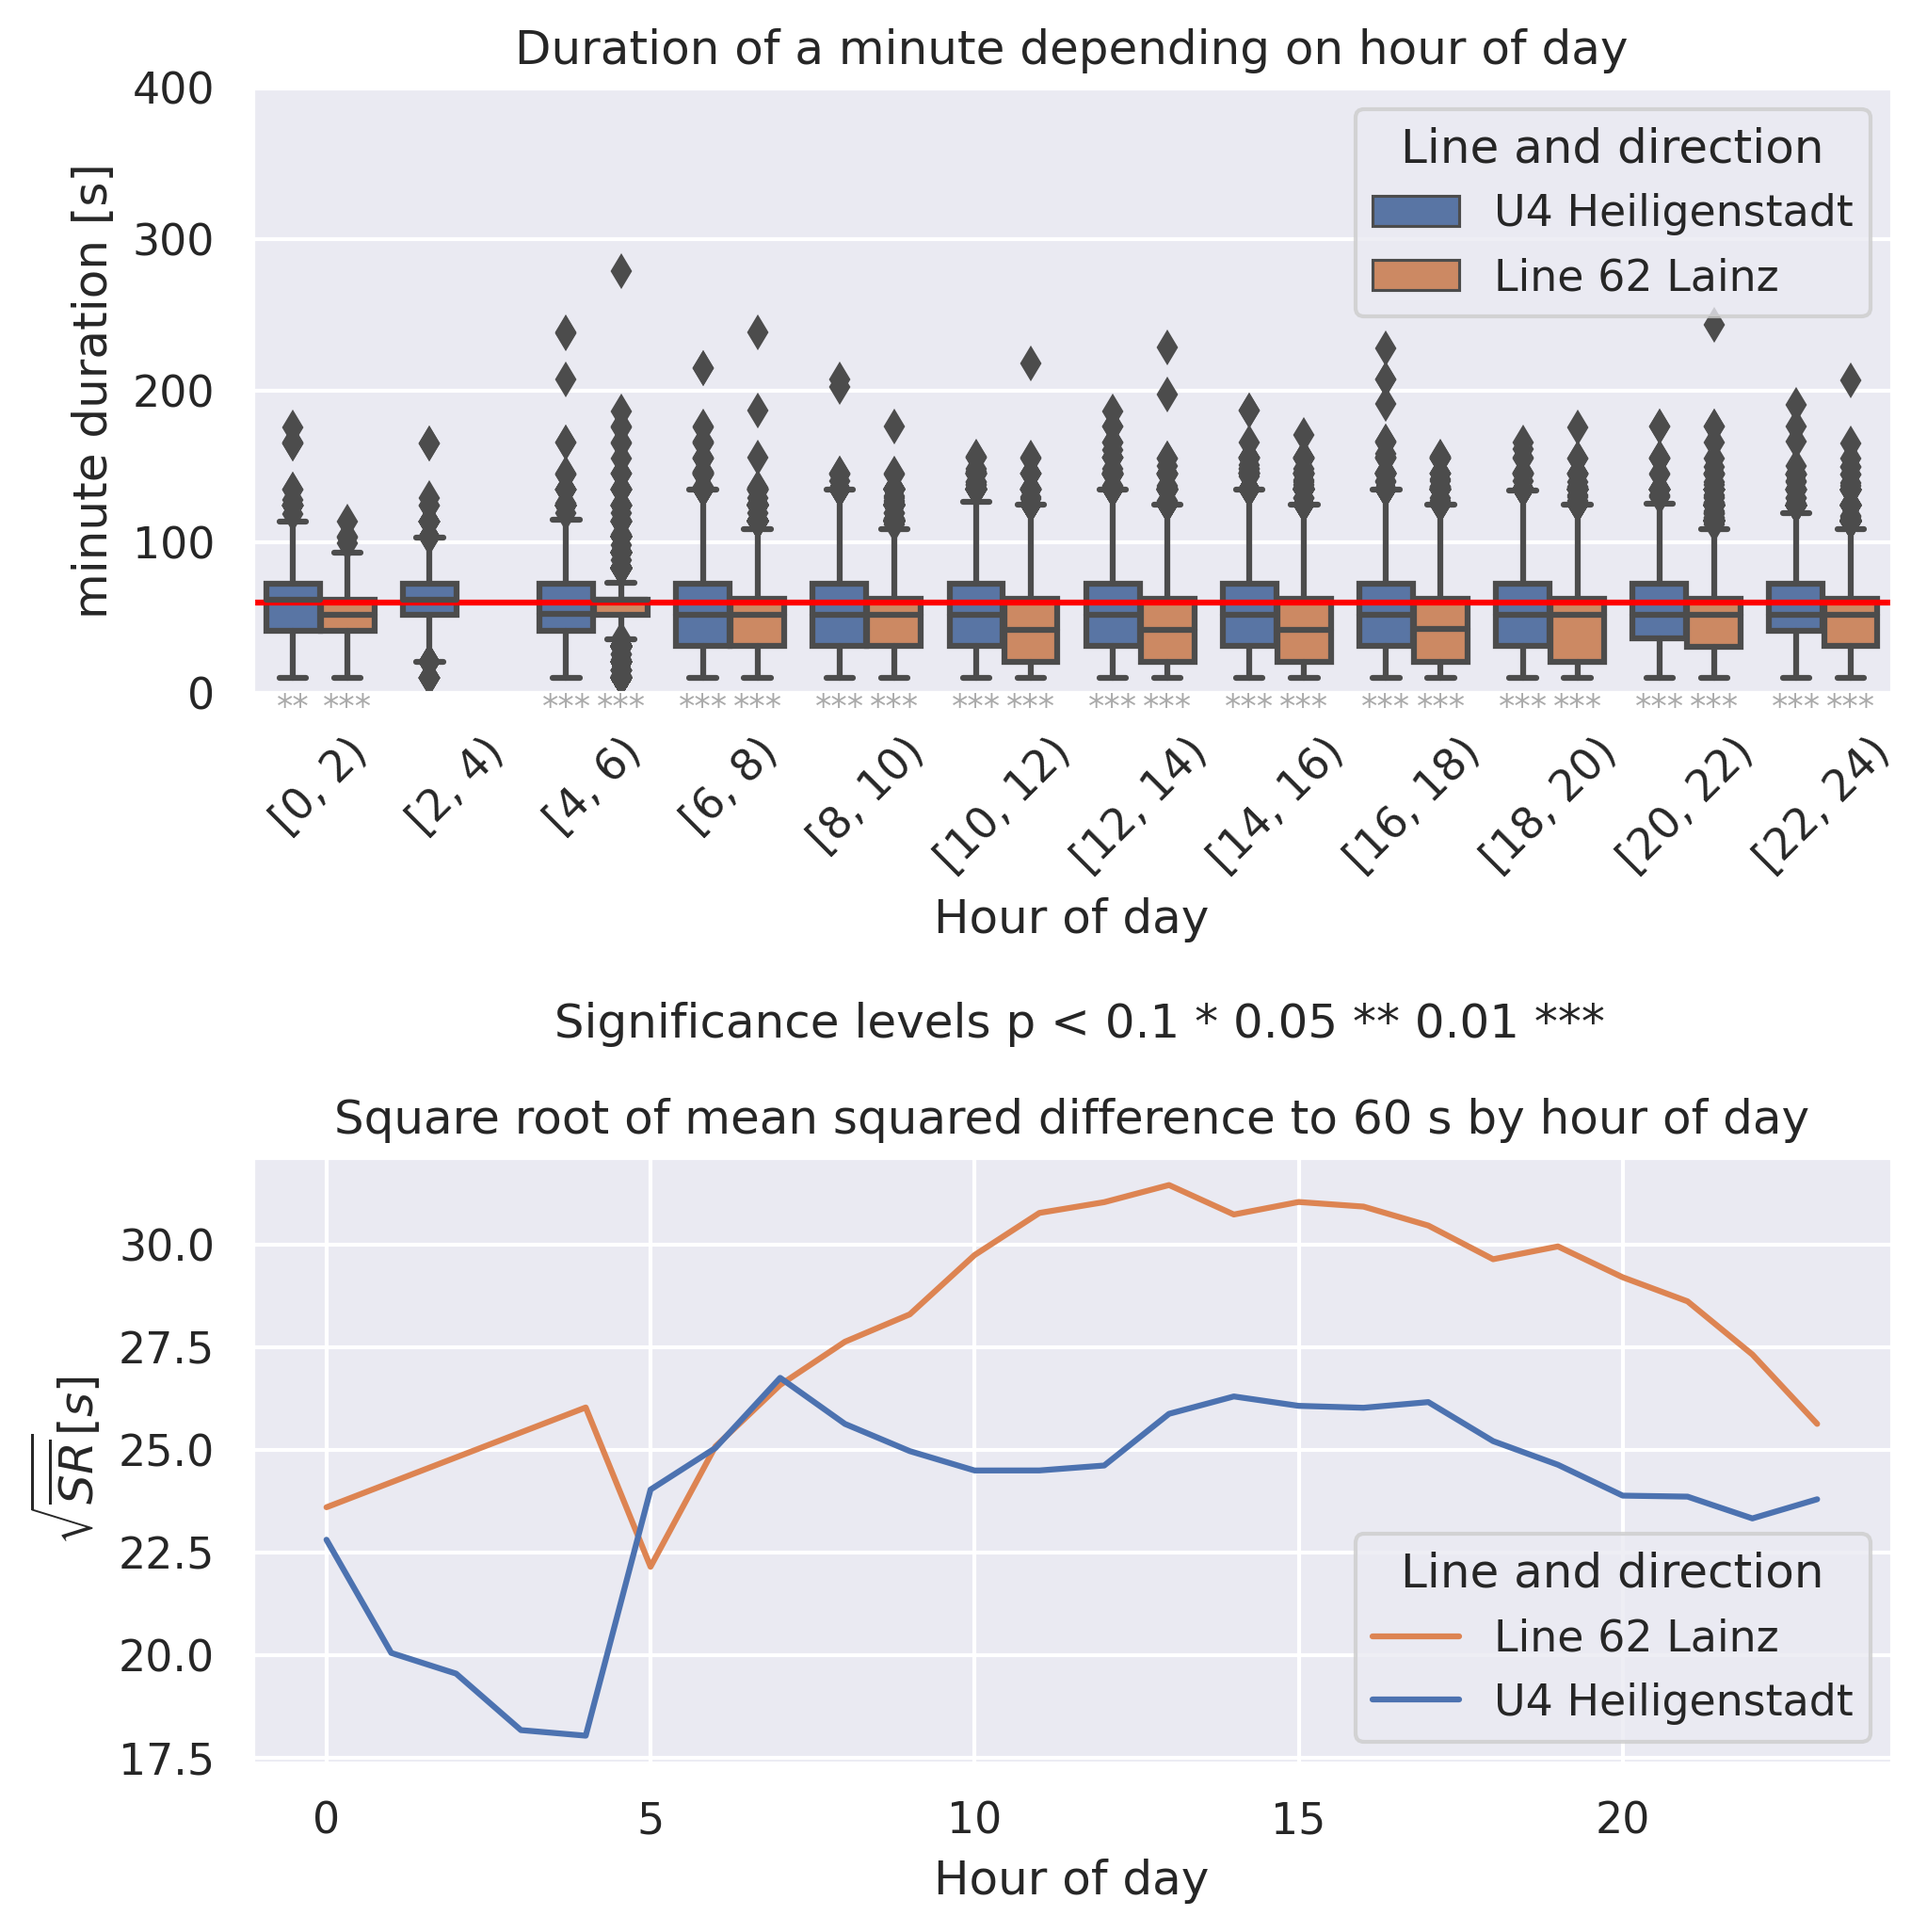

In [15]:


sns.set(rc={'figure.figsize':(7,7), 'figure.dpi':300})

fig, axes = plt.subplots(nrows=2, ncols=1)

# Create plot
sns.boxplot(ax=axes[0], x=pd.cut(nonzero['hour'], np.arange(0,25,2), right=False), y=nonzero['dt'], hue=nonzero['desc'], palette=palette)
#plt.ylim((0,400))
axes[0].set_xlim(-0.5,11.5)
axes[0].set_ylim(0,400)
axes[0].hlines(60, -1, 12, colors='red')
axes[0].set_title('Duration of a minute depending on hour of day')
axes[0].set_xlabel('Hour of day\n \n Significance levels p < 0.1 * 0.05 ** 0.01 ***')
axes[0].set_ylabel('minute duration [s]')
axes[0].legend(title='Line and direction')
axes[0].tick_params(axis='x',rotation=45)

yoffset = -10
n0 = 0
n1 = 0

for i, r in sig_hrs.iterrows():
    if r['desc'] == 'Line 62 Lainz':
        x = n1  + 0.2
        n1 += 1
    else:
        x = n0 - 0.2
        n0 += 1
    
    y = yoffset
    axes[0].text(x, y, r['sig'], ha='center', va='center', fontsize='x-small', color='darkgray')

sns.lineplot(ax=axes[1], x=mean_ssr_hour['hour'], y=np.sqrt(mean_ssr_hour['value']), hue=mean_ssr_hour['desc'], palette=palette)
axes[1].legend(title="Line and direction")
axes[1].set_xlabel("Hour of day")
axes[1].set_ylabel(r'$\sqrt{\overline{SR}} [s]$')
axes[1].set_title('Square root of mean squared difference to 60 s by hour of day')

plt.tight_layout()
plt.savefig('./figures/hour_dependence.png')

<img src="./figures/hour_dependence.png" width=600px>


A certain dependence on the time of day can be observed. The departure times seem to be most accurate in the nighttimes and the largest deviations seem to happen around midday. This effect is less pronounced in the line U4 than 62. This might be due to traffic which does effect line 62 but not U4.

### Cross dependence

The next burning question is, of course, if there are any obvious cross-dependencies for the duration of a minute between time of day and displayed departure time. An adequate tool for this analysis is a heatmap:

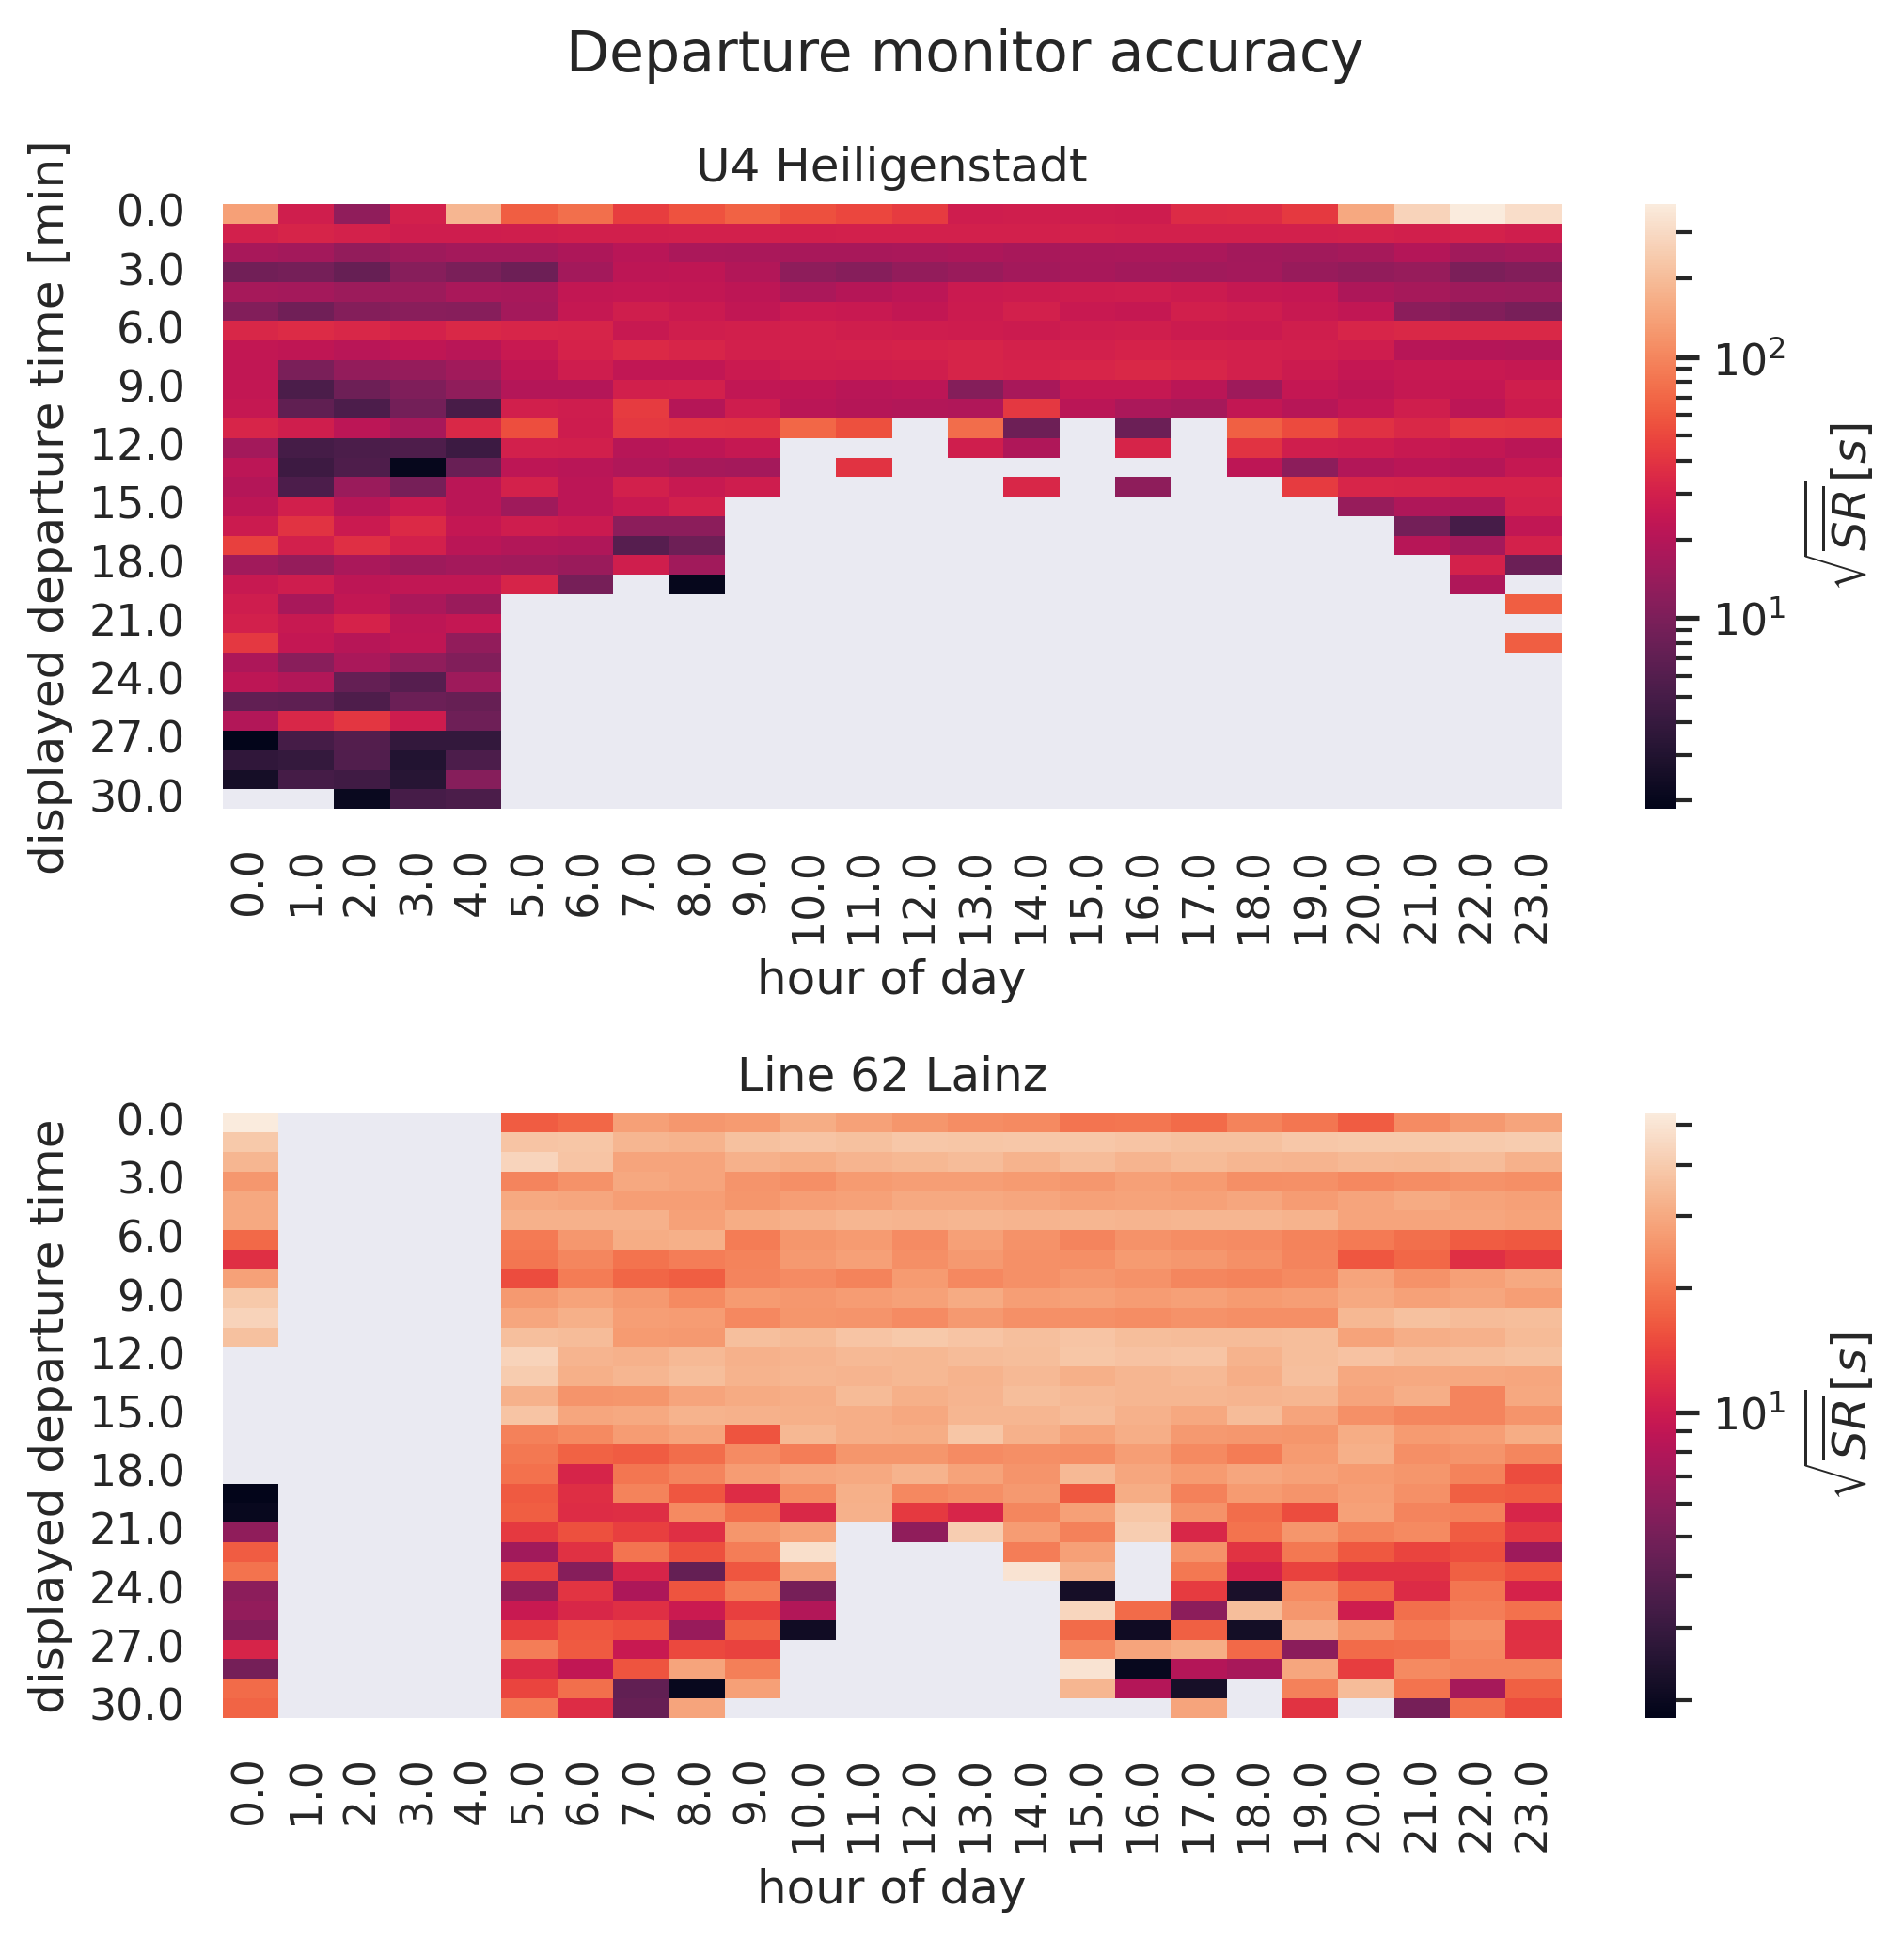

In [16]:
from matplotlib.colors import LogNorm

mean_ssr_complete = combined_df.pivot_table(columns=['desc', 'hour', 'countdown'], values='SR', aggfunc=np.mean).melt()
mean_ssr_complete['sqrt_value'] = np.sqrt(mean_ssr_complete['value'])

heatmap_df_Lainz = mean_ssr_complete.loc[(mean_ssr_complete['desc'] == 'Line 62 Lainz') & (mean_ssr_complete['countdown'] <= 30)]
heatmap_df_Lainz = heatmap_df_Lainz.pivot(columns='hour', index='countdown', values='sqrt_value')

heatmap_df_U4 = mean_ssr_complete.loc[(mean_ssr_complete['desc'] == 'U4 Heiligenstadt') & (mean_ssr_complete['countdown'] <= 30)]
heatmap_df_U4 = heatmap_df_U4.pivot(columns='hour', index='countdown', values='sqrt_value')

# Fix missing hours and sort dataframes
for n in range(0,24):
    if not n in heatmap_df_Lainz.columns:
        heatmap_df_Lainz[n] = np.nan

    if not n in heatmap_df_U4.columns:
        heatmap_df_U4[n] = np.nan

heatmap_df_Lainz = heatmap_df_Lainz[range(0,24)]
heatmap_df_U4 = heatmap_df_U4[range(0,24)]


fig, axes = plt.subplots(nrows=2, ncols=1, sharex=False)

fig.suptitle("Departure monitor accuracy")

sns.heatmap(ax=axes[0], data=heatmap_df_U4, norm=LogNorm(), cbar_kws={'label':'$\sqrt{\overline{SR}} [s]$'})
axes[0].set_title('U4 Heiligenstadt')
axes[0].set_ylabel('displayed departure time [min]')
axes[0].set_xlabel('hour of day')

sns.heatmap(ax=axes[1], data=heatmap_df_Lainz, norm=LogNorm(),cbar_kws={'label':'$\sqrt{\overline{SR}} [s]$'})
axes[1].set_title('Line 62 Lainz')
axes[1].set_ylabel('displayed departure time')
axes[1].set_xlabel('hour of day')

plt.tight_layout()
plt.savefig('./figures/heatmap.png')

<img src="./figures/heatmap.png" width=600px>

## Conclusions

It could be shown that the median duration of a minute differed significantly from 60 seconds on the vast majority of sample groups (grouped by hour of day and displayed departure time). It was also shown that the departure monitors are more accurate at night when there is less trafic and on higher displayed departure times.

Nontheless, the overall mean of the duration of a minute for U4 Heiligenstadt was close to 60 s (57.9 s) although it had a high standard deviation (std = 41.2).

In most evaluated groupings, the median time of a minute was lower than 60 s (overall median 51.9 s and 51.7 s for U4 Heiligenstadt and Line 62 Lainz respectively).

The overall trend on more accurate timings in the nighttime and at higher departure time values was also continued in the heatmaps where hour of day and displayed departure time were combined.

Differences between U4 Heiligenstadt and Line 62 Lainz were minor, although there was an interesting difference when looking at the dependence on the hour of day. While the accuracy of the U4 stayed almost constant during daytime, Line 62 peaked around midday. This might be due to traffic which U4 doesn't experience as it has separate rails.

## Discussion

While this analysis is of no practical use, it shows that if you're waiting for the U4 towards Heiligenstadt or the Line 62 towards Lainz at station Längenfeldgasse, your sub/tram will probably arrive earlier as the departure monitors lead you to believe.

The dataset can also be used to extract other interesting statistics about the Wiener Linien in the future. 

The package created in this work can also be used to gather data from other stations within the Wiener Linien network or even different public transport networks with some modifications to the source code. Redoing this analysis with a dataset pulled at a different point in time could also be an interesting task.